**Note:** If you lanch it first time, so you don't have images in your Google Drive, run this:

In [1]:
# unzip the uploaded data into Google Drive
# !unzip "/content/drive/My Drive/Pneumonia/chest_x_ray.zip" -d "/content/drive/My Drive/Pneumonia/"

# Pneumonia

## Introdution 

This notebook is a binary classifier able to detect pneumonia using chest x-rays. We'll training a neural network that classifies images.

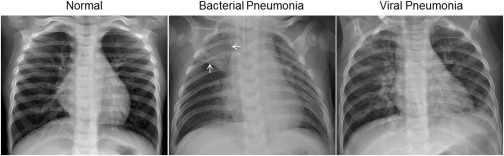

The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.

## 1. Problem

Using TensorFlow, we should predict wheter or not person has a pneumonia.

## 2. Data

The data we're using is from Kaggle : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

## 3. Evaluation

The evaluation is a prediction of probabilities having pneumonia for each image.

## 4. Features

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

### Get our workspace ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU

**Note:** For GPU :
Edit > Notebook settings or Runtime>Change runtime type and select GPU as Hardware accelerator.

In [2]:
# import TensorFlow into Colab
import tensorflow as tf
print("TF version:", tf.__version__)
# import TensorFlow Hub into Colab
import tensorflow_hub as hub
print("TF Hub version:", hub.__version__)
# check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.3.0
TF Hub version: 0.9.0
GPU available


**Preparing the tools:**
* pandas for data analysis
* NumPy for numerical operations
* Matplotlib/seaborn for plotting of data visualization

In [3]:
# regular EDA and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# data parsing
import os
from sklearn.utils import shuffle
# convert images
from matplotlib.pyplot import imread
# view image
import IPython.display as display
# split data
from sklearn.model_selection import train_test_split
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Preparing datasets

We have 3 folders:
* train 
* val
* test

Every folder contains 2 folders with images:
* NORMAL
* PNEUMONIA

So, we'll create a function to prepare datasets:
* for train and val datasets we need to get filenames as features and labels which means wheter or not having pneumonia
* for test datasets we need only to get filenames, because our network shouldn't know labels

In [4]:
# create a function to unpack images and create labels (if we need)
def prepare_data(folder_path, test_data = False):
  """
  Create arrays with filenames and labels 
  with probabilities (like True = 1 and False = 0) for train and test data.
  For test data create an array with filenames.
  folder_path : full path to folder which should unpacked
  test_data : True if test data, False if train or val data
  """
  # path to folders with images
  normal_path, pneumonia_path = folder_path + "/NORMAL/", folder_path + "/PNEUMONIA/"
  # create a lists with filenames
  filenames_normal = [normal_path + file for file in os.listdir(normal_path)] 
  filenames_pneumonia = [pneumonia_path + file for file in os.listdir(pneumonia_path)] 
  filenames = np.concatenate([filenames_normal, filenames_pneumonia])
  # if the data is a test dataset, we probably don't have labels
  if test_data:
    return filenames
  # if the data is a train or val datasets, we need labels
  else:
    # if normal - probability of having pneumonia = 0
    labels_normal = np.zeros(len(filenames_normal))
    # else - probability of having pneumonia = 1
    labels_pneumonia = np.ones(len(filenames_pneumonia))
    return filenames, np.concatenate([labels_normal, labels_pneumonia])

In [5]:
# create features and labels
path_train = "/content/drive/My Drive/Pneumonia/chest_xray/train"
path_val = "/content/drive/My Drive/Pneumonia/chest_xray/val"
path_test = "/content/drive/My Drive/Pneumonia/chest_xray/test"

filenames_train, labels_train = prepare_data(path_train)
filenames_val, labels_val = prepare_data(path_val)
filenames_test, labels_test = prepare_data(path_test)

In [6]:
# check our data
filenames_train[:2], labels_train[:2]

(array(['/content/drive/My Drive/Pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0821-0001.jpeg',
        '/content/drive/My Drive/Pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0836-0001.jpeg'],
       dtype='<U90'), array([0., 0.]))

Let's check how many images we have.

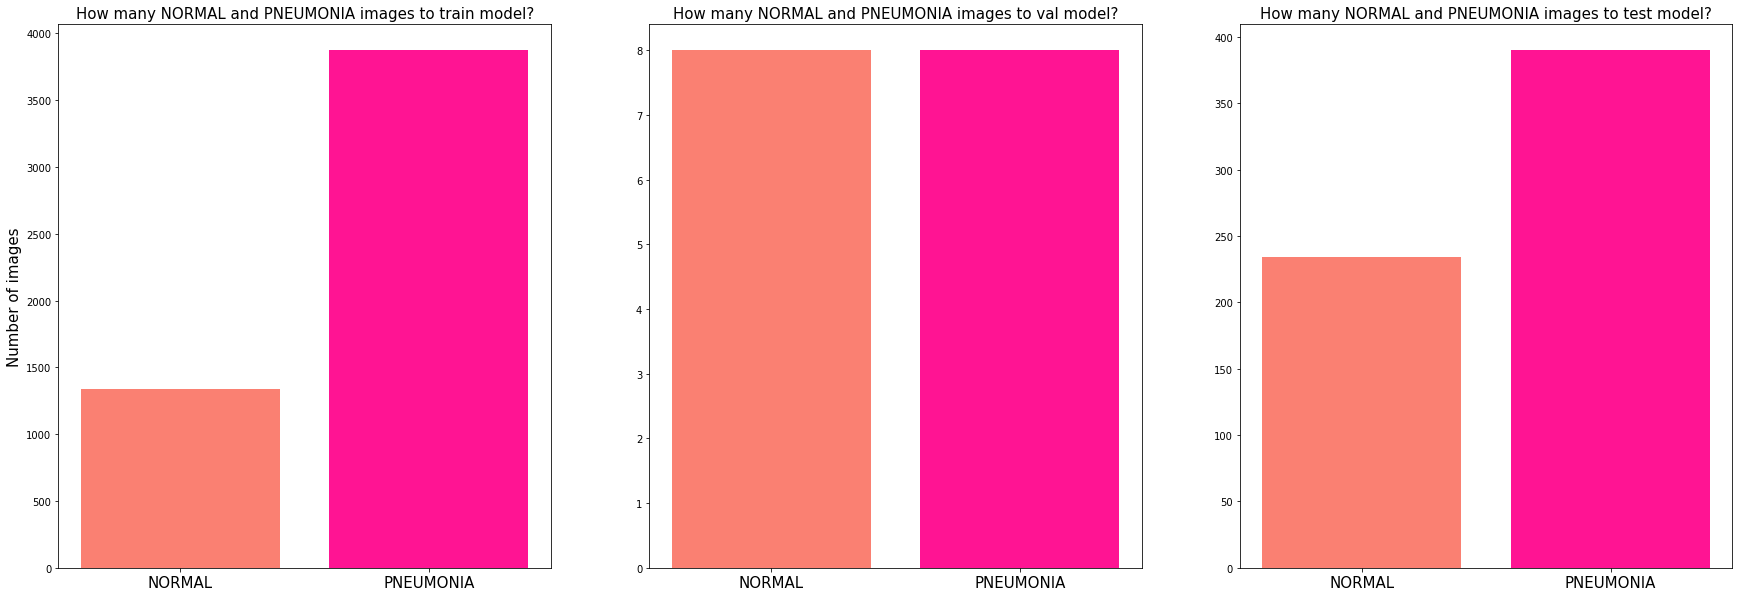

In [7]:
plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.bar(["NORMAL", "PNEUMONIA"], [len(os.listdir(path_train + "/NORMAL")), len(os.listdir(path_train + "/PNEUMONIA"))],
        color=['salmon', 'deeppink'])
plt.title("How many NORMAL and PNEUMONIA images to train model?", size=15)
plt.ylabel("Number of images", size=15);
plt.xticks(size=15)

plt.subplot(1, 3, 2)
plt.bar(["NORMAL", "PNEUMONIA"], [len(os.listdir(path_val + "/NORMAL")), len(os.listdir(path_val + "/PNEUMONIA"))],
        color=['salmon', 'deeppink'])
plt.title("How many NORMAL and PNEUMONIA images to val model?", size=15)
plt.xticks(size=15)

plt.subplot(1, 3, 3)
plt.bar(["NORMAL", "PNEUMONIA"], [len(os.listdir(path_test + "/NORMAL")), len(os.listdir(path_test + "/PNEUMONIA"))],
        color=['salmon', 'deeppink'])
plt.title("How many NORMAL and PNEUMONIA images to test model?", size=15);
plt.xticks(size=15);


### Convert images to Tensors

To fit a neural network, we need all data in numerical format. So, let's convert all our images into Tensors. 
> In TensorFlow Tensors are multidimensional data arrays.

We'll create a function to convert image to Tensor.

In [8]:
# define image size (it can be different for each model)
IMAGE_SIZE = 224

# create a function to convert image to tensor
def convert_image_to_tensor(image_path, image_size=IMAGE_SIZE):
  """
  Convert image to Tensor.
  image_path : full path to image to convert, type `string`
  image_size : required image size for using model
  """
  # take an image frome image path
  image = tf.io.read_file(image_path)
  # convert it to image tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # convert the colour channels values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # pick size
  image = tf.image.resize(image, size=[image_size, image_size])
  return image

In [9]:
# check create_image_to_tensor() on 1 image
convert_image_to_tensor(filenames_train[7])[:2]

<tf.Tensor: shape=(2, 224, 3), dtype=float32, numpy=
array([[[0.03571327, 0.03571327, 0.03571327],
        [0.03392857, 0.03392857, 0.03392857],
        [0.05677522, 0.05677522, 0.05677522],
        ...,
        [0.2142426 , 0.2142426 , 0.2142426 ],
        [0.20264357, 0.20264357, 0.20264357],
        [0.17406994, 0.17406994, 0.17406994]],

       [[0.02921919, 0.02921919, 0.02921919],
        [0.02762605, 0.02762605, 0.02762605],
        [0.05045746, 0.05045746, 0.05045746],
        ...,
        [0.2059695 , 0.2059695 , 0.2059695 ],
        [0.22538544, 0.22538544, 0.22538544],
        [0.16670758, 0.16670758, 0.16670758]]], dtype=float32)>

To make sure that the data is in the correct format and we are ready to build and train the neural network, let's visualize a few images.

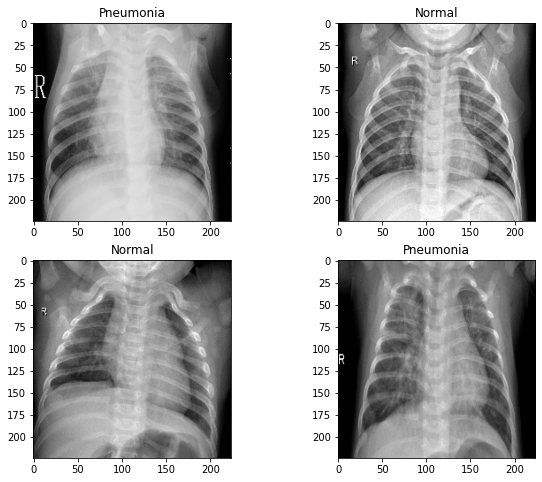

In [10]:
# plot 4 random images
plt.figure(figsize=(10, 8))
for i in range(4):
  plt.subplot(2, 2, i + 1)
  index = np.random.randint(0, len(filenames_train) - 1)
  plt.imshow(convert_image_to_tensor(filenames_train[index]))
  if labels_train[index] == 0:
    title = "Normal"
  else:
    title = "Pneumonia"
  plt.title(title)

## Create data sets 

To train the model, we must have the data in the same format.

So, let's create function to convert all images into Tensors.

In [11]:
# create a simple function to convert a list of images to tensors
def create_images(filenames_path, image_size=IMAGE_SIZE):
  """
  Create a Tensor for all listed images
  filenames_path : ndarray of paths for each image
  image_size : int
  """
  images = []
  # loop for each image and convert it to tensor
  for i in range(len(filenames_path)):
    images.append(convert_image_to_tensor(filenames_path[i]))
  # reshape tensor = [number_of_images, heigth, width, colour_channels]
  images = tf.reshape(images, [len(filenames_path), IMAGE_SIZE, IMAGE_SIZE, 3])
  return images

In [12]:
# create data sets
train_images = create_images(filenames_train)
val_images = create_images(filenames_val)
test_images = create_images(filenames_test)

Check format of data before we'll train a model.

In [13]:
train_images.shape, len(labels_train)

(TensorShape([5216, 224, 224, 3]), 5216)

Now, we are ready to build a model.

## 5. Modeling

### Build a model

To build a model, we should to configure layers.

> The basic building block of a neural network is a layer.

Before we build a model, there are a few things we need to define:

* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (our images shape, in the form of Tensors) to our model.

In [14]:
# setup input shape to the model
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3) # height, width, colour_channels

# setup outnput shape of our model (1 or 0)
OUTPUT_SHAPE = 2

NUM_NEURONS = 350 #@param {type:"slider", min:300, max:1000, step:50}

So, let's create a function to build a model.

A large part of deep learning consists of connections in a sequence of simple segments. 

1. Flatten converts an image format from a two-dimensional array to a one-dimensional one. The layer extracts rows of pixels from the image and arranges them in a single row. This layer has no parameters for training; it only reformats the data.
2. The first Dense layer consists of NUM_NEURONS nodes (or neurons).
3. The second (and last) softmax layer returns an array of OUTPUT_SHAPE probability estimates giving a total of 1. Each node contains an estimate indicating the probability that the image belongs to one of the OUTPUT_SHAPE classes.

In [15]:
# create a function which builds a model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, num_neurons=NUM_NEURONS):
  print("Building model...")

  #setup the model layers
  model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(num_neurons, activation='relu'),
    tf.keras.layers.Dense(output_shape, activation='softmax')
    ])


  # optimizer - function which helps to model improve it's guessing
  model.compile(optimizer='adam',
                # loss = 0 in perfect case - how well model guessing
                loss='sparse_categorical_crossentropy',
                # way of evaluating those guesses
                metrics=['accuracy'])
  print("Ready!")
  return model

In [16]:
# create model
model = create_model()

Building model...
Ready!


In [17]:
# get some information
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 350)               52685150  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 702       
Total params: 52,685,852
Trainable params: 52,685,852
Non-trainable params: 0
_________________________________________________________________


### Creating a callbacks

Callbacks are helper functions a model can use during training to do such things as save it's progress, check it's progress or stop training early if a model stops improving.

We'll create two callbacks for early stopping which prevents our model from training for too long.

**Early Stopping Callback**

Early Stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping


In [18]:
# create Early Stopping Callback
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

### Training a model

Now we are ready to train the model. Let's create a function which trains a model.

* Create a model using create_model()
* Setup a Early Stopping callback
* Call the fit() function on our model passing it in the training data, number of epochs to train for (NUM_EPOCHS) and the create callbacks we'd like to use
* Return the model and the training history

In [19]:
NUM_OF_EPOCHS = 10 #@param {type:"slider", min:10, max:50, step:1}

In [20]:
def train_model(train_images, labels_train, val_images=None, labels_val=None, num_of_epochs=NUM_OF_EPOCHS):
  """
  Trains a given model and returns the trainded version and the training history.
  train_images, labels_train: train data, must have the same size
  val_images, labels_val: validation data, must have the same size, optional parameters
  num_of_epochs : int
  """

  # create a model
  model = create_model()

  # create Early Stopping Callback
  earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
  
  # fit the model to the data passing it the callbacks we created
  if val_images != None:
    history = model.fit(train_images, labels_train, 
                      epochs=num_of_epochs, 
                      verbose=1,
                      validation_data=(val_images, labels_val),
                      shuffle=True,
                      callbacks=[earlystopping])
  else:
    history = model.fit(train_images, labels_train, 
                      epochs=num_of_epochs, 
                      verbose=1,
                      shuffle=True,
                      callbacks=[earlystopping])

  # return the fitted model and the training history
  return model, history

In [21]:
# fit the model to the data
model, history = train_model(train_images, labels_train, val_images, labels_val)

Building model...
Ready!
Epoch 1/10
163/163 [==============================] - 5s 32ms/step - loss: 11.2825 - accuracy: 0.8353 - val_loss: 6.0696 - val_accuracy: 0.6875
Epoch 2/10
163/163 [==============================] - 5s 30ms/step - loss: 1.8988 - accuracy: 0.8972 - val_loss: 1.2285 - val_accuracy: 0.8750
Epoch 3/10
163/163 [==============================] - 5s 30ms/step - loss: 1.0074 - accuracy: 0.9294 - val_loss: 1.0985 - val_accuracy: 0.9375
Epoch 4/10
163/163 [==============================] - 5s 31ms/step - loss: 0.7457 - accuracy: 0.9346 - val_loss: 2.3180 - val_accuracy: 0.8125
Epoch 5/10
163/163 [==============================] - 5s 30ms/step - loss: 0.5616 - accuracy: 0.9400 - val_loss: 0.9731 - val_accuracy: 0.8750
Epoch 6/10
163/163 [==============================] - 5s 30ms/step - loss: 0.8100 - accuracy: 0.9241 - val_loss: 3.1482 - val_accuracy: 0.6875


Let's plot model training history.

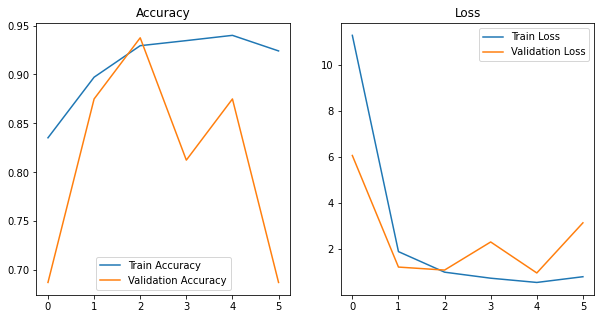

In [22]:
# create a function to plot training history
def plot_history(history):
  """
  Plot training history by train and validation data, including accuracy and loss
  history : result of model fitting
  """
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'],label='Train Accuracy')
  plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
  plt.legend()
  plt.title("Accuracy")

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'],label='Train Loss')
  plt.plot(history.history['val_loss'],label='Validation Loss')
  plt.legend()
  plt.title("Loss");

plot_history(history)

### Making and evaluating predictions using a trained model

In [23]:
# make predictions on the test data (not used to train on)
predictions = model.predict(test_images, verbose=1)
predictions

20/20 [==============================] - 0s 11ms/step


array([[5.3279630e-09, 1.0000000e+00],
       [5.0996814e-04, 9.9949002e-01],
       [8.7352231e-20, 1.0000000e+00],
       ...,
       [6.2493949e-31, 1.0000000e+00],
       [4.3113733e-14, 1.0000000e+00],
       [2.7535519e-34, 1.0000000e+00]], dtype=float32)

In [24]:
# let's check accuracy and loss on test data
def check_accuracy_loss(model, X_test, y_test):
  """
  Check accuracy and loss on test data
  """
  test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=1)

  print(f"\nAccuracy on test data: {test_acc * 100:2.0f} %")
  print('\nLoss on test data:', test_loss)
  return test_loss, test_acc

check_accuracy_loss(model, test_images,  labels_test)

20/20 [==============================] - 0s 12ms/step - loss: 6.4763 - accuracy: 0.7051

Accuracy on test data: 71 %

Loss on test data: 6.476294040679932


(6.476294040679932, 0.7051281929016113)

In [25]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  prediction_probabilities: ndarray of predictions made by model
  labels : list of y_test values
  images : list of unbatched test images
  """
  pred_prob, true_prob, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = "Normal" if np.argmax(pred_prob) == 0 else "Pneumonia"
  # Get the true label
  true_label = "Normal" if true_prob == 0 else "Pneumonia"

  # Plot image & remove ticks
  plt.imshow(convert_image_to_tensor(image))
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is wright or wrong
  if pred_label == true_label:
    colour = "green"
  else:
    colour = "red"

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label, pred_prob[np.argmax(pred_prob)] * 100, true_label), color=colour)

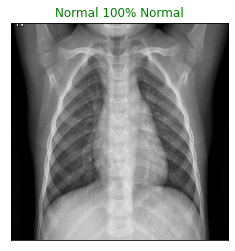

In [26]:
# check plot_pred() function
plot_pred(predictions, labels_test, filenames_test, n=22)

In [27]:
# create a function to view predictions
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus prediction confidences along with the truth label for sample n.
  prediction_probabilities: ndarray of predictions made by model
  labels : list of y_test values
  """
  pred_prob, true_prob = prediction_probabilities[n], labels[n]

  # Get the pred label
  pred_label = "Normal" if np.argmax(pred_prob) == 0 else "Pneumonia"
  # Get the true label
  true_label = "Normal" if true_prob == 0 else "Pneumonia"

  values = pred_prob
  labels = ["Normal", "Pneumonia"]

  # Plot image & remove ticks
  top_plot = plt.bar(np.arange(len(labels)),
                     values, 
                     color="grey")
  plt.xticks(np.arange(len(labels)), labels=labels, rotation='horizontal')

  # change the colour of wright probability
  if true_label == "Normal":
    top_plot[0].set_color("green")
  else:
    top_plot[1].set_color("green")

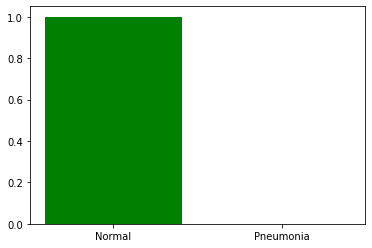

In [28]:
# check plot_pred_conf() function
plot_pred_conf(predictions, labels_test, n=22)


Check out a few predictions and their different values.

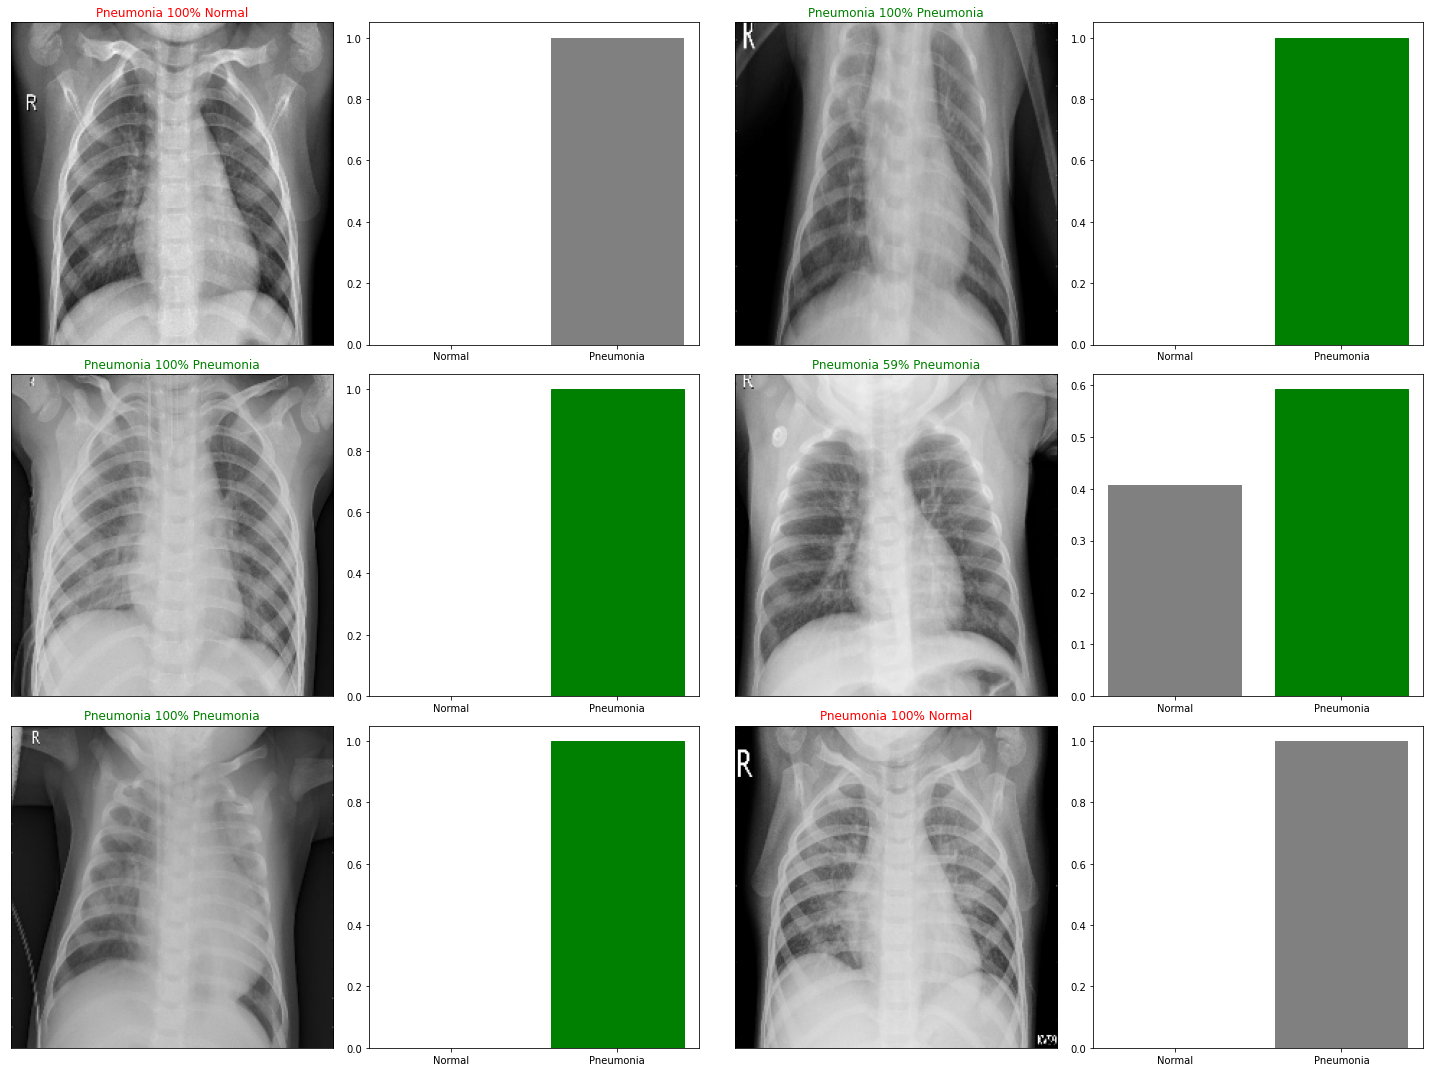

In [29]:
def plot_random_predictions(predictions, filenames_test, y_test):
  """
  Plot random 6 images and their probabilities.
  """
  num_rows = 3
  num_cols = 2
  num_images = num_rows * num_cols
  plt.figure(figsize=(10 * num_cols, 5 * num_rows))
  for i in range(num_images):
    index = np.random.randint(0, len(y_test)-1)
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_pred(predictions, y_test, filenames_test, index)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(predictions, y_test, index)
  plt.tight_layout(h_pad=1.0)
  plt.show()

plot_random_predictions(predictions, filenames_test, labels_test)

### Confusion matrix

Let's plot confusion matrix.

Because we have each prediction size equal 2 (probability of having and not pneumonia), we should parse them as format as test labels.


In [30]:
# parse predictions
predictions_for_cf = []
for pred in predictions:
  predictions_for_cf.append(np.argmax(pred))

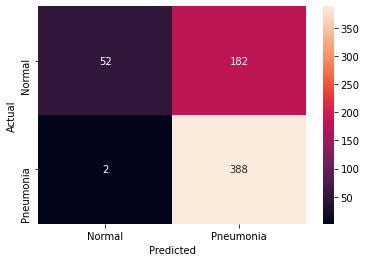

In [31]:
# plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
  """
  Plot a confusion matrix
  """
  conf_matrix = confusion_matrix(y_true, y_pred)
  labels = ["Normal", "Pneumonia"]

  sns.heatmap(conf_matrix,annot=True,fmt='g',xticklabels=labels,yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual');

plot_confusion_matrix(labels_test, predictions_for_cf)

### Model improvement

Let's improve our model by adding layers.

* Dropout is a method of regularizing our model to prevent overfitting
* MaxPooling2D is a way to reduce the number of parameters in our model by moving the 2x2 pool filter over the previous layer and taking a maximum of 4 values in the 2x2 filter.

To complete the architecture of our model, let's add a fully linked layer and then an output layer.

In [32]:
# create a function which improve a model
def create_improve_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, num_neurons=NUM_NEURONS):
  print("Building model...")

  #setup the model layers
  model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3),activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_neurons, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(output_shape, activation='softmax')
    ])


  # optimizer - function which helps to model improve it's guessing
  model.compile(optimizer='adam',
                # loss = 0 in perfect case - how well model guessing
                loss='sparse_categorical_crossentropy',
                # way of evaluating those guesses
                metrics=['accuracy'])
  print("Ready!")
  return model

In [33]:
# create model
improve_model = create_improve_model()

Building model...
Ready!


In [34]:
# get some information
improve_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 394272)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 350)               137995550 
_________________________________________________________________
dropout_1 (Dropout)          (None, 350)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

Let's fit our improve model.

In [35]:
def train_improve_model(train_images, labels_train, val_images=None, labels_val=None, num_of_epochs=NUM_OF_EPOCHS):
  """
  Trains a given model and returns the trainded version and the training history.
  train_images, labels_train: train data, must have the same size
  val_images, labels_val: validation data, must have the same size, optional parameters
  num_of_epochs : int
  """

  # create a model
  model = create_improve_model()

  # create Early Stopping Callback
  earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
  
  # fit the model to the data passing it the callbacks we created
  if val_images != None:
    history = model.fit(train_images, labels_train, 
                      epochs=num_of_epochs, 
                      verbose=1,
                      validation_data=(val_images, labels_val),
                      shuffle=True,
                      callbacks=[earlystopping])
  else:
    history = model.fit(train_images, labels_train, 
                      epochs=num_of_epochs, 
                      verbose=1,
                      shuffle=True,
                      callbacks=[earlystopping])

  # return the fitted model and the training history
  return model, history

In [36]:
# fit the model to the data
improve_model, improve_history = train_improve_model(train_images, labels_train, val_images, labels_val)

Building model...
Ready!
Epoch 1/10
163/163 [==============================] - 18s 112ms/step - loss: 3.2504 - accuracy: 0.8493 - val_loss: 0.4431 - val_accuracy: 0.7500
Epoch 2/10
163/163 [==============================] - 18s 110ms/step - loss: 0.1812 - accuracy: 0.9323 - val_loss: 0.3052 - val_accuracy: 0.8750
Epoch 3/10
163/163 [==============================] - 18s 110ms/step - loss: 0.1589 - accuracy: 0.9388 - val_loss: 0.1351 - val_accuracy: 0.9375
Epoch 4/10
163/163 [==============================] - 18s 111ms/step - loss: 0.1361 - accuracy: 0.9456 - val_loss: 1.1466 - val_accuracy: 0.6875
Epoch 5/10
163/163 [==============================] - 18s 110ms/step - loss: 0.1189 - accuracy: 0.9519 - val_loss: 0.1857 - val_accuracy: 0.9375
Epoch 6/10
163/163 [==============================] - 18s 110ms/step - loss: 0.1085 - accuracy: 0.9546 - val_loss: 0.1063 - val_accuracy: 1.0000
Epoch 7/10
163/163 [==============================] - 18s 110ms/step - loss: 0.0886 - accuracy: 0.9688 - 

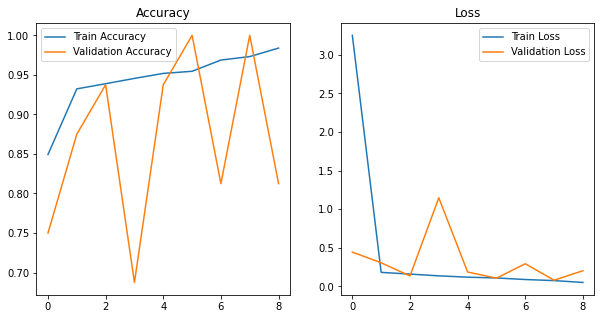

In [37]:
plot_history(improve_history)

In [38]:
# make predictions on the test data (not used to train on)
improve_predictions = improve_model.predict(test_images, verbose=1)
improve_predictions

20/20 [==============================] - 0s 24ms/step


array([[1.3591522e-01, 8.6408484e-01],
       [4.2334039e-04, 9.9957663e-01],
       [2.9014131e-05, 9.9997103e-01],
       ...,
       [2.2468003e-08, 1.0000000e+00],
       [6.0187438e-10, 1.0000000e+00],
       [5.0252488e-08, 1.0000000e+00]], dtype=float32)

In [43]:
# let's compare accuracy and loss on model and improvment model
print("Model")
check_accuracy_loss(model, test_images,  labels_test)
print("Improve model")
check_accuracy_loss(improve_model, test_images,  labels_test)

Model
20/20 [==============================] - 0s 14ms/step - loss: 6.4763 - accuracy: 0.7051

Accuracy on test data: 71 %

Loss on test data: 6.476294040679932
Improve model
20/20 [==============================] - 1s 31ms/step - loss: 1.9075 - accuracy: 0.7244

Accuracy on test data: 72 %

Loss on test data: 1.9074902534484863


(1.9074902534484863, 0.7243589758872986)

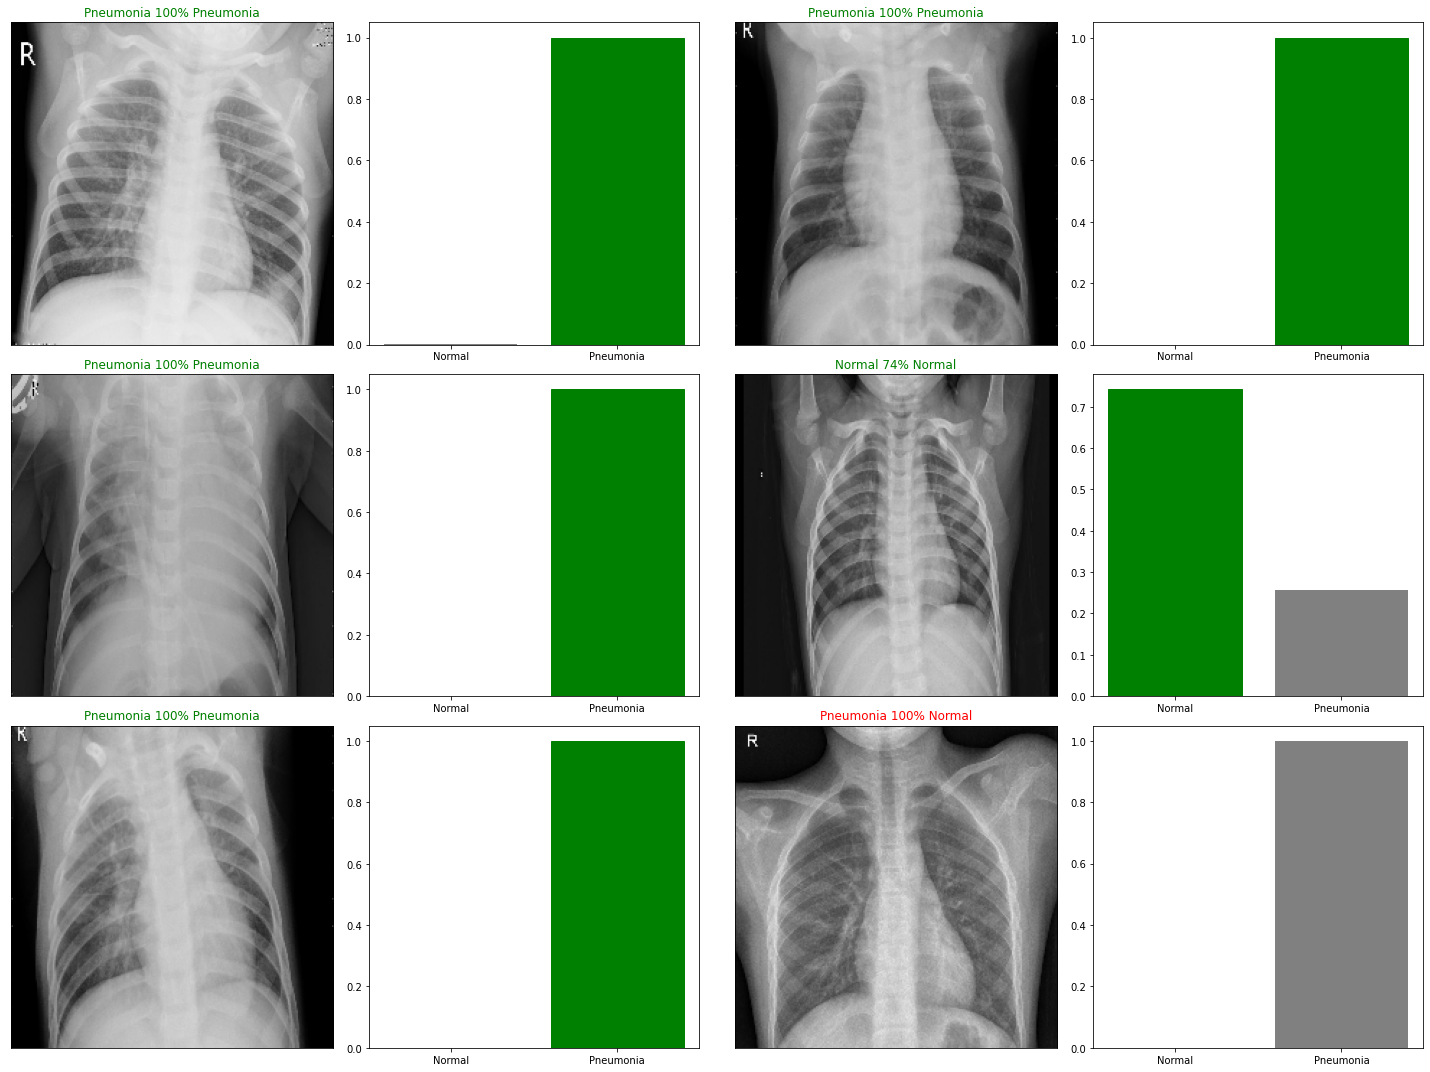

In [40]:
# check out a few predictions and their different values
plot_random_predictions(improve_predictions, filenames_test, labels_test)

In [41]:
# parse predictions
improve_predictions_for_cf = []
for pred in improve_predictions:
  improve_predictions_for_cf.append(np.argmax(pred))

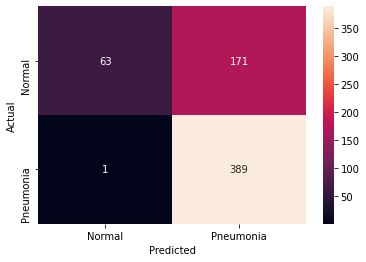

In [42]:
# plot confusion matrix
plot_confusion_matrix(labels_test, improve_predictions_for_cf)